<a href="https://colab.research.google.com/github/jugalpanchal/bd-chef/blob/main/spark_etl_crime_anlys_recipe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Spark Session

In [1]:
# Follow the steps to install the dependencies:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # install java
!wget -q https://downloads.apache.org/spark/spark-3.1.2/spark-3.1.2-bin-hadoop3.2.tgz # spark package download
!tar xf spark-3.1.2-bin-hadoop3.2.tgz # unzip spark package
!pip install -q findspark # install spark

# Set the location of Java and Spark:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop3.2"

import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession

# create or get spark session
spark = SparkSession.builder \
        .master("local[*]") \
        .appName("Spark_App1") \
        .getOrCreate()

sc = spark.sparkContext

### Read a file

In [3]:
data = spark.read\
            .format("csv")\
            .option("header", "true")\
            .load("datasets/london_crime_by_lsoa.csv")

data.count() #DataFrame count

11237281

In [4]:
# easy alternative
#data = spark.read.csv('datasets/london_crime_by_lsoa.csv', inferSchema=True, header=True)
data.printSchema()
data.show()
data.limit(5).show() # top 5

root
 |-- lsoa_code: string (nullable = true)
 |-- borough: string (nullable = true)
 |-- major_category: string (nullable = true)
 |-- minor_category: string (nullable = true)
 |-- value: string (nullable = true)
 |-- year: string (nullable = true)
 |-- month: string (nullable = true)

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01001116|             Croydon|            Burglary|Burglary in Other...|    0|2016|   11|
|E01001646|           Greenwich|Violence Against ...|      Other violence|    0|2016|   11|
|E01000677|             Bromley|Violence Against ...|      Other violence|    0|2015|    5|
|E01003774|           Redbridge|            Burglary|Burglary in Other...|    0|2016|    3|
|E01004563|          Wandsworth|             Robbery|   Personal Pro

### NA, Drop Column, Select, Distinct, Filter(==, isin, >=), Sample-Fraction 

In [5]:
data = data.dropna() # Drop NA values records(Rows)
data.count()

11237281

In [6]:
data.drop("lsoa_code")
total_borough = data.select("borough")\
    .distinct()

total_borough.show()

+--------------------+
|             borough|
+--------------------+
|             Croydon|
|          Wandsworth|
|              Bexley|
|             Lambeth|
|Barking and Dagenham|
|              Camden|
|           Greenwich|
|              Newham|
|       Tower Hamlets|
|            Hounslow|
|              Barnet|
|              Harrow|
|Kensington and Ch...|
|           Islington|
|               Brent|
|            Haringey|
|             Bromley|
|              Merton|
|         Westminster|
|             Hackney|
+--------------------+
only showing top 20 rows



In [7]:
hackney_data = data.filter(data['borough'] == 'Hackney')
hackney_data.show(5) # any 5

+---------+-------+--------------------+--------------------+-----+----+-----+
|lsoa_code|borough|      major_category|      minor_category|value|year|month|
+---------+-------+--------------------+--------------------+-----+----+-----+
|E01001786|Hackney|     Criminal Damage|Criminal Damage T...|    0|2011|    6|
|E01001794|Hackney|Violence Against ...|          Harassment|    1|2013|    2|
|E01001787|Hackney|     Criminal Damage|Other Criminal Da...|    0|2011|    7|
|E01001738|Hackney|Violence Against ...|        Wounding/GBH|    0|2013|   12|
|E01001807|Hackney|  Theft and Handling|  Other Theft Person|    0|2016|    8|
+---------+-------+--------------------+--------------------+-----+----+-----+
only showing top 5 rows



In [8]:
data_2015_2016 = data.filter(data['year'].isin(['2015', '2016'])) 
#data_2015_2016.count() # 2997912
data_2015_2016_fra_per = data_2015_2016.sample(fraction=0.000002) # Ex 0.2 means 20% so it creates a new dataframe with 20% data from source
data_2015_2016_fra_per.show()

+---------+--------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|       borough|      major_category|      minor_category|value|year|month|
+---------+--------------+--------------------+--------------------+-----+----+-----+
|E01004461|Waltham Forest|Violence Against ...| Assault with Injury|    0|2015|    5|
|E01003623|        Newham|Violence Against ...|        Wounding/GBH|    0|2015|    8|
|E01033575|        Newham|  Theft and Handling|         Other Theft|    4|2016|    1|
|E01033456|         Brent|     Criminal Damage|Criminal Damage T...|    0|2015|    7|
|E01000726|       Bromley|            Burglary|Burglary in a Dwe...|    1|2016|    7|
+---------+--------------+--------------------+--------------------+-----+----+-----+



In [9]:
data_data_onwards = data.filter(data['year'] >= 2016)
data_data_onwards.sample(fraction = 0.1).show() #10%

+---------+--------------------+--------------------+--------------------+-----+----+-----+
|lsoa_code|             borough|      major_category|      minor_category|value|year|month|
+---------+--------------------+--------------------+--------------------+-----+----+-----+
|E01002006|            Haringey|     Criminal Damage|Criminal Damage T...|    0|2016|   12|
|E01001600|           Greenwich|            Burglary|Burglary in Other...|    0|2016|   11|
|E01002804|           Islington|  Theft and Handling|Theft/Taking Of M...|    0|2016|    6|
|E01002884|Kensington and Ch...|Other Notifiable ...|    Other Notifiable|    0|2016|   10|
|E01004598|          Wandsworth|  Theft and Handling|Handling Stolen G...|    0|2016|    2|
|E01004485|          Wandsworth|Violence Against ...|          Harassment|    0|2016|    4|
|E01002703|           Islington|  Theft and Handling|Handling Stolen G...|    0|2016|   11|
|E01001124|             Croydon|Other Notifiable ...|    Other Notifiable|    0|

### Aggregation - groupBy, agg, orderBy, sort

In [10]:
borough_and_count = data.groupBy('borough')\
                        .count()

borough_and_count.show()

+--------------------+------+
|             borough| count|
+--------------------+------+
|             Croydon|501433|
|          Wandsworth|415715|
|              Bexley|320831|
|             Lambeth|432146|
|Barking and Dagenham|259168|
|              Camden|315660|
|           Greenwich|350670|
|              Newham|392956|
|       Tower Hamlets|343009|
|            Hounslow|329702|
|              Barnet|477311|
|              Harrow|305095|
|Kensington and Ch...|247585|
|           Islington|299106|
|               Brent|408524|
|            Haringey|344575|
|             Bromley|436434|
|              Merton|283265|
|         Westminster|305400|
|             Hackney|347818|
+--------------------+------+
only showing top 20 rows



In [11]:
# the sum is a method and the value is column in the dataframe.
#data = data.sample(fraction = 0.001)
borought_conviction_sum = data.groupBy('borough')\
                              .agg({"value":"sum"})\
                              .withColumnRenamed("sum(value)", "convictions")

borought_conviction_sum.show()

+--------------------+-----------+
|             borough|convictions|
+--------------------+-----------+
|             Croydon|   216386.0|
|          Wandsworth|   170727.0|
|              Bexley|    95066.0|
|             Lambeth|   242161.0|
|Barking and Dagenham|   124617.0|
|              Camden|   228545.0|
|           Greenwich|   151159.0|
|              Newham|   218057.0|
|       Tower Hamlets|   190803.0|
|            Hounslow|   155754.0|
|              Barnet|   177147.0|
|              Harrow|    97319.0|
|Kensington and Ch...|   142641.0|
|           Islington|   191670.0|
|               Brent|   189676.0|
|            Haringey|   177785.0|
|             Bromley|   153619.0|
|              Merton|    96406.0|
|         Westminster|   376399.0|
|             Hackney|   180910.0|
+--------------------+-----------+
only showing top 20 rows



In [12]:
borought_conviction_sum_total = borought_conviction_sum.agg({"convictions":"sum"})
borought_conviction_sum_total.show()
total_convictions = borought_conviction_sum_total.collect()[0][0] # 0 row and 0 column

+----------------+
|sum(convictions)|
+----------------+
|       5363374.0|
+----------------+



In [13]:
import pyspark.sql.functions as func
from pyspark.sql.functions import lit # literal

# Somehow it is not working.
borought_conviction_per = borought_conviction_sum.withColumn("contribution percentage(%)", 
                                                             func.round(borought_conviction_sum.convictions / total_convictions * 100, 2)\
                                                             )
borought_conviction_per.show(5)

+--------------------+-----------+--------------------------+
|             borough|convictions|contribution percentage(%)|
+--------------------+-----------+--------------------------+
|             Croydon|   216386.0|                      4.03|
|          Wandsworth|   170727.0|                      3.18|
|              Bexley|    95066.0|                      1.77|
|             Lambeth|   242161.0|                      4.52|
|Barking and Dagenham|   124617.0|                      2.32|
+--------------------+-----------+--------------------------+
only showing top 5 rows



In [14]:
# 2 column - contribution percentage(%)
borought_conviction_per.orderBy(borought_conviction_per[2].desc())\
                        .show()

+--------------+-----------+--------------------------+
|       borough|convictions|contribution percentage(%)|
+--------------+-----------+--------------------------+
|   Westminster|   376399.0|                      7.02|
|       Lambeth|   242161.0|                      4.52|
|     Southwark|   231783.0|                      4.32|
|        Camden|   228545.0|                      4.26|
|        Newham|   218057.0|                      4.07|
|       Croydon|   216386.0|                      4.03|
|        Ealing|   208748.0|                      3.89|
|     Islington|   191670.0|                      3.57|
| Tower Hamlets|   190803.0|                      3.56|
|         Brent|   189676.0|                      3.54|
|       Hackney|   180910.0|                      3.37|
|      Lewisham|   178642.0|                      3.33|
|      Haringey|   177785.0|                      3.31|
|        Barnet|   177147.0|                       3.3|
|    Hillingdon|   174260.0|                    

In [15]:
conviction_monthly = data.filter(data['year'] == 2014)\
                          .groupBy('month')\
                          .agg({"value":"sum"})\
                          .withColumnRenamed("sum(value)", "convictions")

conviction_monthly.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|    7|    48697.0|
|   11|    49586.0|
|    3|    47864.0|
|    8|    46412.0|
|    5|    46787.0|
|    6|    47763.0|
|    9|    46967.0|
|    1|    46162.0|
|   10|    50289.0|
|    4|    44345.0|
|   12|    47602.0|
|    2|    42687.0|
+-----+-----------+



In [16]:
conviction_monthly_sort = conviction_monthly.sort(conviction_monthly.convictions.desc())
conviction_monthly_sort.show()

+-----+-----------+
|month|convictions|
+-----+-----------+
|   10|    50289.0|
|   11|    49586.0|
|    7|    48697.0|
|    3|    47864.0|
|    6|    47763.0|
|   12|    47602.0|
|    9|    46967.0|
|    5|    46787.0|
|    8|    46412.0|
|    1|    46162.0|
|    4|    44345.0|
|    2|    42687.0|
+-----+-----------+



### Convert the column values to column names

In [17]:
# Two columns - 1st, 2nd
# New column - value from 1st column, Values from 2nd column, ...
data.crosstab('borough', 'major_category')\
    .select('borough_major_category', 'Burglary', 'Drugs', 'Fraud or Forgery', 'Robbery')\
    .show()

+----------------------+--------+-----+----------------+-------+
|borough_major_category|Burglary|Drugs|Fraud or Forgery|Robbery|
+----------------------+--------+-----+----------------+-------+
|              Havering|   26985|27180|            4600|  23114|
|                Merton|   22314|24361|            4722|  19693|
|              Haringey|   26095|29507|            8643|  24573|
|         Tower Hamlets|   25898|31239|            4503|  23686|
|               Bromley|   35457|35376|            7161|  28886|
|               Enfield|   32887|36603|            8075|  29472|
|  Kingston upon Thames|   17511|18455|            3144|  13043|
|           Westminster|   23058|27141|            7195|  20819|
|  Richmond upon Thames|   20590|19334|            2348|  15298|
|              Lewisham|   30356|36302|            9171|  28965|
|                 Brent|   31009|39199|            7732|  28397|
|  Barking and Dagenham|   19739|21910|            6016|  18418|
|             Redbridge| 

### Plot - MatPlotLib

> Indented block



In [18]:
%matplotlib inline

import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [19]:
def describe_year(year):
    yearly_details = data.filter(data.year == year)\
                         .groupBy('borough')\
                         .agg({'value':'sum'})\
                         .withColumnRenamed("sum(value)","convictions")
    
    borough_list = [x[0] for x in yearly_details.toLocalIterator()]
    convictions_list = [x[1] for x in yearly_details.toLocalIterator()]
  
    plt.figure(figsize=(33, 10)) 
    plt.bar(borough_list, convictions_list)
    
    plt.title('Crime for the year: ' + year, fontsize=30)
    plt.xlabel('Boroughs',fontsize=30)
    plt.ylabel('Convictions', fontsize=30)

    plt.xticks(rotation=90, fontsize=30)
    plt.yticks(fontsize=30)
    plt.autoscale()
    plt.show()

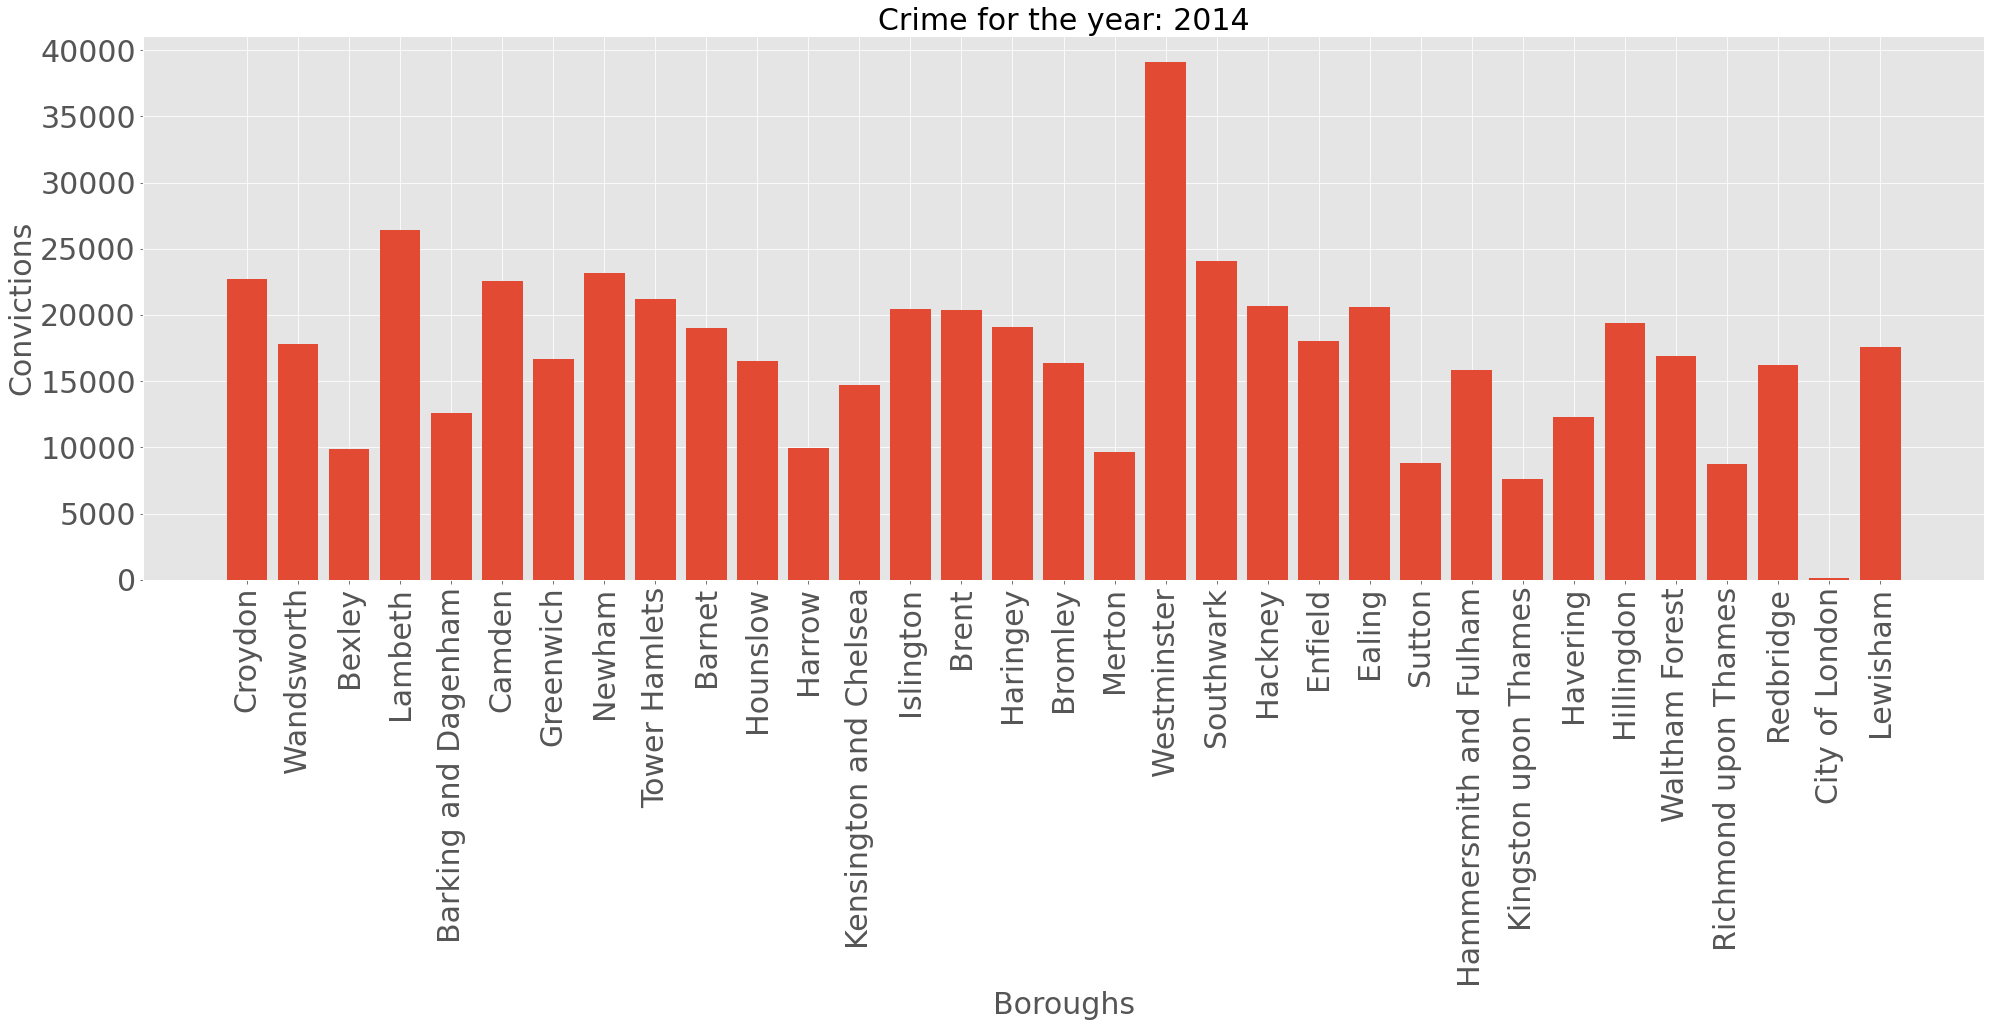

In [20]:
describe_year('2014')